# 00. Goal

Your R&D task is the following:

1. Select a few languages that use similiar alphabet (between 5 and 10 languages)
2. Among these languages, there should be at least 2 that are considered to be very similiar to each other (and therefore challenging for language identification)
3. Build a prototype of Deep Learning solution that will have more than 95% accuracy in language identification (classification) task
4. The accuracy should be checked based on reference texts of length 140 characters (Tweet/SMS length)
5. Other classifiction parameters (like precision and recall) should be well balanced

I decided to recognize language of text using Deep Neural Network. For this, I will build a prototype DNN classifier for 7 European languages: English, German, French, Italian, Spanish, Czech and Slovakian. We will train and test it with texts sourced from Wikipedia. 
NOTE: This notebook is CPU and memory consuing. You have been warned :)

# 01. Notebook Intro & Imports

Deep Learning Language Identification Notebook

* Notebook @author Lukasz Kamieniecki-Mruk, lucas.mlexp@gmail.com, http://machinelearningexp.com
* Notebook License: Creative Commons CC-BY-SA https://creativecommons.org/licenses/by-sa/4.0/
* Dataset source: https://dumps.wikimedia.org
* Dataset license:  GNU Free Documentation License (GFDL) and the Creative Commons Attribution-Share-Alike 3.0 License

In [1]:
# imports
import os
import re
import math
import random
import collections
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import classification_report
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
import keras.optimizers
from keras.utils import plot_model
print("Keras backend : ", keras.backend.backend())

Using TensorFlow backend.


Keras backend :  tensorflow


In [2]:
# key variables
# dictionary of languages that our classifier will cover
languages_dict = {'en':0,'fr':1,'es':2,'it':3,'de':4,'sk':5,'cs':6}
# length of cleaned text used for training and prediction - 140 chars
text_sample_size = 140
# number of language samples per language that we will extract from source files
num_lang_samples = 250000

# utility function to turn language id into language code
def decode_langid(langid):    
    for dname, did in languages_dict.items():
        if did == langid:
            return dname

# utility function to return file Bytes size in MB
def size_mb(size):
    size_mb =  '{:.2f}'.format(size/(1000*1000.0))
    return size_mb + " MB"

# we will use alphabet for text cleaning and letter counting
def define_alphabet():
    base_en = 'abcdefghijklmnopqrstuvwxyz'
    special_chars = ' !?¿¡'
    german = 'äöüß'
    italian = 'àèéìíòóùú'
    french = 'àâæçéèêêîïôœùûüÿ'
    spanish = 'áéíóúüñ'
    czech = 'áčďéěíjňóřšťúůýž'
    slovak = 'áäčďdzdžéíĺľňóôŕšťúýž'
    all_lang_chars = base_en + german +  italian + french + spanish + czech + slovak
    small_chars = list(set(list(all_lang_chars)))
    small_chars.sort() 
    big_chars = list(set(list(all_lang_chars.upper())))
    big_chars.sort()
    small_chars += special_chars
    letters_string = ''
    letters = small_chars + big_chars
    for letter in letters:
        letters_string += letter
    return small_chars,big_chars,letters_string

alphabet = define_alphabet()
print (alphabet)

(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'ß', 'à', 'á', 'â', 'ä', 'æ', 'ç', 'è', 'é', 'ê', 'ì', 'í', 'î', 'ï', 'ñ', 'ò', 'ó', 'ô', 'ö', 'ù', 'ú', 'û', 'ü', 'ý', 'ÿ', 'č', 'ď', 'ě', 'ĺ', 'ľ', 'ň', 'œ', 'ŕ', 'ř', 'š', 'ť', 'ů', 'ž', ' ', '!', '?', '¿', '¡'], ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'À', 'Á', 'Â', 'Ä', 'Æ', 'Ç', 'È', 'É', 'Ê', 'Ì', 'Í', 'Î', 'Ï', 'Ñ', 'Ò', 'Ó', 'Ô', 'Ö', 'Ù', 'Ú', 'Û', 'Ü', 'Ý', 'Č', 'Ď', 'Ě', 'Ĺ', 'Ľ', 'Ň', 'Œ', 'Ŕ', 'Ř', 'Š', 'Ť', 'Ů', 'Ÿ', 'Ž'], 'abcdefghijklmnopqrstuvwxyzßàáâäæçèéêìíîïñòóôöùúûüýÿčďěĺľňœŕřšťůž !?¿¡ABCDEFGHIJKLMNOPQRSTUVWXYZÀÁÂÄÆÇÈÉÊÌÍÎÏÑÒÓÔÖÙÚÛÜÝČĎĚĹĽŇŒŔŘŠŤŮŸŽ')


# 02. Raw Data preparation

Before I could run this notebook, I had to prepare the data. 
What we need is a big block of text for each language we want to identify. We will sample randomly from each block during our DNN training, validation and test.

**[A]**. I downloaded Wikipedia dump files from page: https://dumps.wikimedia.org. 
I decided to download " All pages, current versions only" and files packed into bz2 archives, less compressed than 7zip files, thus smaller after decompression. Example file name: enwiki-20170301-pages-meta-current1.xml-p000000010p000030303.bz2

I downloaded random files for each of the following languages:
* English (enwiki files)
* French (frwiki files)
* Spanish (eswiki files)
* Italian (itwiki files)
* German (dewiki files)
* Czech (cswiki files)
* Slovakian (skwiki files)

My package had around 8,5 GB of data so prepare enough storage on your disk.

**[B]**. I extracted text from the files using Wikipedia Extractor Python package http://medialab.di.unipi.it/wiki/Wikipedia_Extractor
I run the extractor with parameters to get files of around 100 MB in size. This way, I could easily select some of them to create data for our Neural Network.
Consult Wikipedia Extractor page for details of using this package.  
Example command in shell: python WikiExtractor.py -b 100000K /users/luke/Documents/ML\ Datasets/WIKI_DUMPS/enwiki-20170301-pages-meta-current1.xml-p000000010p000030303.bz2

**[C]**. As a result, I got several extracted files for each language (named wiki_00, wiki_01 etc): 
 * I selected manually some of them (pseudo-randomly ;) to get approximately 200 MB of data for each language.
 * I merged the files for each language to get one, big file for each language. I did merging with my Mac shell "cat" command. You can use command from your OS or use python to do that.
 * I named the files according to 2-digit language ISO code. As a result, I have tteh following files in my data directory now:
en.txt, fr.txt, es.txt, it.txt, de.txt, cs.txt, sk.txt

In [3]:
# I keep raw data in 'original' subfolder, and cleaned data in 'cleaned' subfolder
# 'samples' subdirectory is for files with text samples processed according to my sampling procedure
# 'train_test' subdirecrory is for files with np.arrays prepared for NN train and test data (both features and targets)
data_directory = "./Data/"
source_directory = data_directory + 'source'
cleaned_directory = data_directory + 'cleaned'
samples_directory = data_directory + 'samples'
train_test_directory = data_directory + 'train_test'

for filename in os.listdir(source_directory):
    path = os.path.join(source_directory, filename)
    if not filename.startswith('.'):
        print((path), "size : ",size_mb(os.path.getsize(path)))

./Data/source/cs.txt size :  204.79 MB
./Data/source/de.txt size :  204.76 MB
./Data/source/en.txt size :  204.75 MB
./Data/source/es.txt size :  204.77 MB
./Data/source/fr.txt size :  204.72 MB
./Data/source/it.txt size :  204.78 MB
./Data/source/sk.txt size :  204.78 MB


In [4]:
# we will create here several text-cleaning procedures. 
# These procedure will help us to clean the data we have for training, 
# but also will be useful in cleaning the text we want to classify, before the classification by trained DNN

# remove XML tags procedure
# for example, Wikipedia Extractor creates tags like this below, we need to remove them
# <doc id="12" url="https://en.wikipedia.org/wiki?curid=12" title="Anarchism"> ... </doc>
def remove_xml(text):
    return re.sub(r'<[^<]+?>', '', text)

# remove new lines - we need dense data
def remove_newlines(text):
    return text.replace('\n', ' ') 
    
# we need only alpha characters and some (very limited) special characters
# exactly the ones defined in the alphabet
# no numbers, most of special characters also bring no value for our classification task
# (like dot or comma - they are the same in all of our languages so does not bring additional informational value)
def only_alphabet_chars(text,alphabet):
    return re.sub('[^'+alphabet[2]+']', ' ', text) #if not in pattern, replace with space

# replace many spaces in text with one space - too many spaces is unnecesary
# we want to keep single spaces between words
# as this can tell DNN about average length of the word and this may be useful feature
def remove_manyspaces(text):
    return re.sub(r'\s+', ' ', text)

# and here the whole procedure together
def clean_text(text):
    text = remove_xml(text)
    text = only_alphabet_chars(text,alphabet)
    text = remove_newlines(text)
    text = remove_manyspaces(text)
    return text

In [5]:
for lang_code in languages_dict:
    path_src = os.path.join(source_directory, lang_code+".txt")
    f = open(path_src)
    content = f.read()
    print('Language : ',lang_code)
    print ('Content before cleaning :-> ',content[1000:1000+text_sample_size])
    f.close()
    # cleaning
    content = clean_text(content)
    print ('Content after cleaning :-> ',content[1000:1000+text_sample_size])
    path_cl = os.path.join(cleaned_directory,lang_code + '_cleaned.txt')
    f = open(path_cl,'w')
    f.write(content)
    f.close()
    del content
    print ("Cleaning completed for : " + path_src,'->',path_cl)
    print (100*'-')
print ("END OF CLEANING")

Language :  en
Content before cleaning :->  osophy. Many types and traditions of anarchism exist, not all of which are mutually exclusive. Anarchist schools of thought can differ funda
Content after cleaning :->  ist schools of thought can differ fundamentally supporting anything from extreme individualism to complete collectivism Strains of anarchism
Cleaning completed for : ./Data/source/en.txt -> ./Data/cleaned/en_cleaned.txt
----------------------------------------------------------------------------------------------------
Language :  fr
Content before cleaning :->   très tôt ses distances avec l'esprit contestataire de 1968.

Avec plus de quatorze prix et neuf nominations, l'art cinématographique de Pie
Content after cleaning :->  o Pasolini s impose dès avec notamment L Évangile selon saint Matthieu puis avec Les Contes de Canterbury Premier né des enfants de Carlo Al
Cleaning completed for : ./Data/source/fr.txt -> ./Data/cleaned/fr_cleaned.txt
---------------------------------

# 03. Input Data Preparation 

In [6]:
# this function will get sample of texh from each cleaned language file. 
# It will try to preserve complete words - if word is to be sliced, sample will be shortened to full word
def get_sample_text(file_content,start_index,sample_size):
    # we want to start from full first word
    # if the firts character is not space, move to next ones
    while not (file_content[start_index].isspace()):
        start_index += 1
    #now we look for first non-space character - beginning of any word
    while file_content[start_index].isspace():
        start_index += 1
    end_index = start_index+sample_size 
    # we also want full words at the end
    while not (file_content[end_index].isspace()):
        end_index -= 1
    return file_content[start_index:end_index]
    
# count number of chars in text based on given alphabet
def count_chars(text,alphabet):
    alphabet_counts = []
    for letter in alphabet:
        count = text.count(letter)
        alphabet_counts.append(count)
    return alphabet_counts

# process text and return sample input row for DNN
# note that we are counting separatey:
# a) counts of all letters regardless of their size (whole text turned to lowercase letter)
# b) counts of big letters only
# this is because German uses big letters for beginning of nouns so this feature is meaningful
def get_input_row(content,start_index,sample_size):
    sample_text = get_sample_text(content,start_index,sample_size)
    counted_chars_all = count_chars(sample_text.lower(),alphabet[0])
    counted_chars_big = count_chars(sample_text,alphabet[1])
    all_parts = counted_chars_all + counted_chars_big
    return all_parts
    
# let's see if our processing is returning counts
# last part calculates also input_size for DNN so this code must be run before DNN is trained
path = os.path.join(cleaned_directory, "de_cleaned.txt")
with open(path, 'r') as f:
    content = f.read()
    random_index = random.randrange(0,len(content)-2*text_sample_size)
    sample_text = get_sample_text(content,random_index,text_sample_size)
    print ("1. Sample text: \n",sample_text)
    print ("2. Reference alphabet: \n",alphabet[0],alphabet[1])
    sample_input_row = get_input_row(content,random_index,text_sample_size)
    print ("3. Sample_input_row: \n",sample_input_row)
    input_size = len(sample_input_row)
    print ("4. Input size : ", input_size)
    del content

1. Sample text: 
 installiert Der Eingang zu Millennium Force befindet sich hinter der Station am Celebration Plaza der Parkeisenbahn Cedar Point Lake Erie
2. Reference alphabet: 
 ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'ß', 'à', 'á', 'â', 'ä', 'æ', 'ç', 'è', 'é', 'ê', 'ì', 'í', 'î', 'ï', 'ñ', 'ò', 'ó', 'ô', 'ö', 'ù', 'ú', 'û', 'ü', 'ý', 'ÿ', 'č', 'ď', 'ě', 'ĺ', 'ľ', 'ň', 'œ', 'ŕ', 'ř', 'š', 'ť', 'ů', 'ž', ' ', '!', '?', '¿', '¡'] ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'À', 'Á', 'Â', 'Ä', 'Æ', 'Ç', 'È', 'É', 'Ê', 'Ì', 'Í', 'Î', 'Ï', 'Ñ', 'Ò', 'Ó', 'Ô', 'Ö', 'Ù', 'Ú', 'Û', 'Ü', 'Ý', 'Č', 'Ď', 'Ě', 'Ĺ', 'Ľ', 'Ň', 'Œ', 'Ŕ', 'Ř', 'Š', 'Ť', 'Ů', 'Ÿ', 'Ž']
3. Sample_input_row: 
 [11, 3, 4, 5, 18, 2, 2, 3, 13, 0, 2, 7, 3, 12, 4, 3, 0, 10, 4, 8, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [8]:
# now we have preprocessing utility functions ready. Let's use them to process each cleaned language file
# and turn text data into numerical data samples for our neural network
# prepare numpy array
sample_data = np.empty((num_lang_samples*len(languages_dict),input_size+1),dtype = np.uint16)
lang_seq = 0
jump_reduce = 0.2 # part of characters removed from jump to avoid passing the end of file
for lang_code in languages_dict:
    start_index = 0
    path = os.path.join(cleaned_directory, lang_code+"_cleaned.txt")
    with open(path, 'r') as f:
        print ("Processing file : " + path)
        file_content = f.read()
        content_length = len(file_content)
        remaining = content_length - text_sample_size*num_lang_samples
        jump = int(((remaining/num_lang_samples)*3)/4)
        print ("File size : ",size_mb(content_length),\
               " | # possible samples : ",int(content_length/input_size),\
              "| # skip chars : " + str(jump))
        for idx in range(num_lang_samples):
            input_row = get_input_row(file_content,start_index,text_sample_size)
            sample_data[num_lang_samples*lang_seq+idx,] = input_row + [languages_dict[lang_code]]
            start_index += text_sample_size + jump
        del file_content
    lang_seq += 1
    print (100*"-")
     
# let's randomy shuffle the data
np.random.shuffle(sample_data)
# reference input size
print ("Input size : ",input_size )
print (100*"-")
print ("Samples array size : ",sample_data.shape )
path_smpl = os.path.join(samples_directory,"lang_samples_"+str(input_size)+".npz")
np.savez_compressed(path_smpl,data=sample_data)
print(path_smpl, "size : ",size_mb(os.path.getsize(path_smpl)))
del sample_data

Processing file : ./Data/cleaned/en_cleaned.txt
File size :  189.13 MB  | # possible samples :  1432771 | # skip chars : 462
----------------------------------------------------------------------------------------------------
Processing file : ./Data/cleaned/fr_cleaned.txt
File size :  184.54 MB  | # possible samples :  1398019 | # skip chars : 448
----------------------------------------------------------------------------------------------------
Processing file : ./Data/cleaned/es_cleaned.txt
File size :  188.65 MB  | # possible samples :  1429192 | # skip chars : 460
----------------------------------------------------------------------------------------------------
Processing file : ./Data/cleaned/it_cleaned.txt
File size :  186.30 MB  | # possible samples :  1411339 | # skip chars : 453
----------------------------------------------------------------------------------------------------
Processing file : ./Data/cleaned/de_cleaned.txt
File size :  187.81 MB  | # possible samples :  

In [9]:
# now we will review the data  - control check step
path_smpl = os.path.join(samples_directory,"lang_samples_"+str(input_size)+".npz")
dt = np.load(path_smpl)['data']
random_index = random.randrange(0,dt.shape[0])
print ("Sample record : \n",dt[random_index,])
print ("Sample language : ",decode_langid(dt[random_index,][input_size]))
# we can also check if the data have equal share of different languages
print ("Dataset shape :", dt.shape)
bins = np.bincount(dt[:,input_size])
print ("Language bins count : ") 
for lang_code in languages_dict: 
    print (lang_code,bins[languages_dict[lang_code]])

Sample record : 
 [12  2  2  5  9  0  0  2  5  1  2  4  2  7  9  5  0  3  9 10  3  8  0  0  1
  5  0  0  3  0  0  0  0  0  1  0  0  2  0  0  0  0  0  0  0  0  0  0  0  2
  0  2  0  1  0  0  0  0  0  1  0  0  1  0 16  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  6]
Sample language :  cs
Dataset shape : (1750000, 133)
Language bins count : 
en 250000
fr 250000
es 250000
it 250000
de 250000
sk 250000
cs 250000


In [10]:
# we need to preprocess data for DNN yet again - scale it 
# scling will ensure that our optimization algorithm (variation of gradient descent) will converge well
# we need also ensure one-hot econding of target classes for softmax output layer
# let's convert datatype before processing to float
dt = dt.astype(np.float64)
# X and Y split
X = dt[:,0:input_size]
Y = dt[:,input_size]
del dt
# random index to check random sample
random_index = random.randrange(0,X.shape[0])
print("Example data before processing:")
print("X : \n", X[random_index,])
print("Y : \n", Y[random_index])
time.sleep(120) # sleep time to allow release memory. This step is very memory consuming
# X preprocessing
# standar scaler will be useful laterm during DNN prediction
standard_scaler = preprocessing.StandardScaler().fit(X)
X = standard_scaler.transform(X)   
print ("X preprocessed shape :", X.shape)
# Y one-hot encoding
Y = keras.utils.to_categorical(Y, num_classes=len(languages_dict))
# See the sample data
print("Example data after processing:")
print("X : \n", X[random_index,])
print("Y : \n", Y[random_index])
# train/test split. Static seed to have comparable results for different runs
seed = 42
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=seed)
del X, Y
# wait for memory release again
time.sleep(120)
# save train/test arrays to file
path_tt = os.path.join(train_test_directory,"train_test_data_"+str(input_size)+".npz")
np.savez_compressed(path_tt,X_train=X_train,Y_train=Y_train,X_test=X_test,Y_test=Y_test)
print(path_tt, "size : ",size_mb(os.path.getsize(path_tt)))
del X_train,Y_train,X_test,Y_test

Example data before processing:
X : 
 [  4.   2.   5.   3.  21.   2.   6.   8.  11.   0.   1.   5.   2.  12.   5.
   1.   0.   7.   8.   9.   3.   2.   3.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  19.   0.   0.   0.   0.   2.   1.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   1.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
Y : 
 4.0
X preprocessed shape : (1750000, 132)
Example data after processing:
X : 
 [ -1.57614104e+00   1.73736578e-01   5.21140845e-01  -7.95180097e-01
   1.56745616e+00   4.78904105e-01   2.55776912e+00   2.20287335e+00
   7.35414771e-01  -6.26447607e-01  -3.11148534e-01  -3.07854181e-01


# 04. Train & Test Deep Neural Network

In [12]:
# load train data first from file
path_tt = os.path.join(train_test_directory,"train_test_data_"+str(input_size)+".npz")
train_test_data = np.load(path_tt)
X_train = train_test_data['X_train']
print ("X_train: ",X_train.shape)
Y_train = train_test_data['Y_train']
print ("Y_train: ",Y_train.shape)
X_test = train_test_data['X_test']
print ("X_test: ",X_test.shape)
Y_test = train_test_data['Y_test']
print ("Y_test: ",Y_test.shape)
del train_test_data

X_train:  (1400000, 132)
Y_train:  (1400000, 7)
X_test:  (350000, 132)
Y_test:  (350000, 7)


In [13]:
# create DNN using Keras Sequential API
# I added Dropout to prevent overfitting
model = Sequential()
model.add(Dense(500,input_dim=input_size,kernel_initializer="glorot_uniform",activation="sigmoid"))
model.add(Dropout(0.5))
model.add(Dense(300,input_dim=input_size,kernel_initializer="glorot_uniform",activation="sigmoid"))
model.add(Dropout(0.5))
model.add(Dense(100,input_dim=input_size,kernel_initializer="glorot_uniform",activation="sigmoid"))
model.add(Dropout(0.5))
model.add(Dense(len(languages_dict),kernel_initializer="glorot_uniform",activation="softmax"))
model_optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy',
              optimizer=model_optimizer,
              metrics=['accuracy'])

In [14]:
# let's fit the data
# history variable will help us to plot results later
history = model.fit(X_train,Y_train,
          epochs=12,
          validation_split=0.10,
          batch_size=64,
          verbose=2,
          shuffle=True)

Train on 1260000 samples, validate on 140000 samples
Epoch 1/12
272s - loss: 0.1196 - acc: 0.9631 - val_loss: 0.0739 - val_acc: 0.9763
Epoch 2/12
251s - loss: 0.0883 - acc: 0.9737 - val_loss: 0.0717 - val_acc: 0.9775
Epoch 3/12
279s - loss: 0.0841 - acc: 0.9748 - val_loss: 0.0697 - val_acc: 0.9779
Epoch 4/12
233s - loss: 0.0817 - acc: 0.9755 - val_loss: 0.0694 - val_acc: 0.9778
Epoch 5/12
247s - loss: 0.0802 - acc: 0.9761 - val_loss: 0.0671 - val_acc: 0.9784
Epoch 6/12
255s - loss: 0.0792 - acc: 0.9762 - val_loss: 0.0677 - val_acc: 0.9789
Epoch 7/12
237s - loss: 0.0786 - acc: 0.9766 - val_loss: 0.0664 - val_acc: 0.9790
Epoch 8/12
245s - loss: 0.0780 - acc: 0.9768 - val_loss: 0.0667 - val_acc: 0.9784
Epoch 9/12
246s - loss: 0.0779 - acc: 0.9768 - val_loss: 0.0668 - val_acc: 0.9788
Epoch 10/12
255s - loss: 0.0771 - acc: 0.9771 - val_loss: 0.0657 - val_acc: 0.9792
Epoch 11/12
261s - loss: 0.0772 - acc: 0.9772 - val_loss: 0.0664 - val_acc: 0.9791
Epoch 12/12
256s - loss: 0.0768 - acc: 0.97

In [15]:
# now we will face the TRUTH. What is our model real accuracy tested on unseen data?
scores = model.evaluate(X_test, Y_test, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

349824/350000 [============================>.] - ETA: 0s  

In [16]:
# and now we will prepare data for scikit-learn classification report
Y_pred = model.predict_classes(X_test)
Y_pred = keras.utils.to_categorical(Y_pred, num_classes=len(languages_dict))

349408/350000 [============================>.] - ETA: 0s   

In [17]:
# and run the report
target_names =  list(languages_dict.keys())
print(classification_report(Y_test, Y_pred, target_names=target_names))

             precision    recall  f1-score   support

         en       0.97      0.98      0.98     50538
         fr       0.98      0.98      0.98     49991
         es       0.98      0.98      0.98     50223
         it       0.97      0.97      0.97     50146
         de       0.99      0.99      0.99     49334
         sk       0.97      0.98      0.98     49963
         cs       0.99      0.97      0.98     49805

avg / total       0.98      0.98      0.98    350000



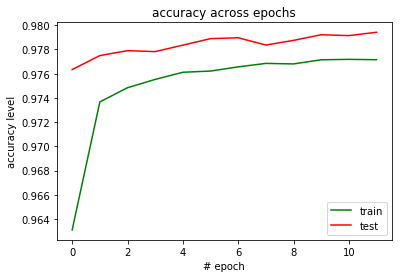

In [18]:
# show plot accuracy changes during training
plt.plot(history.history['acc'],'g')
plt.plot(history.history['val_acc'],'r')
plt.title('accuracy across epochs')
plt.ylabel('accuracy level')
plt.xlabel('# epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

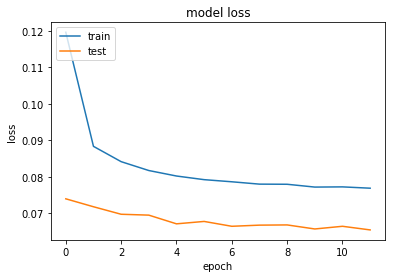

In [19]:
# show plot of loss changes during training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [20]:
# and now we will have some fun. Seeing is believing!
# We will take some texts and try to predict the text's language using our trained neural network.

# Frank Baum, The Wonderful Wizard of Oz, Project Gutenberg, public domain
en_text = "You are welcome, most noble Sorceress, to the land of the Munchkins. We are so grateful to you \
for having killed the Wicked Witch of the East, and for setting our people free from bondage."
# Johann Wolfgang von Goethe, Faust: Der Tragödie erster Teil, Project Gutenberg, public domain
de_text = "Habe nun, ach! Philosophie, Juristerei und Medizin, Und leider auch Theologie \
Durchaus studiert, mit heißem Bemühn. Da steh ich nun, ich armer Tor! Und bin so klug als wie zuvor;"
# Pierre Benoît, L'Atlantide, 
fr_text = "Voilà cinq mois que j'en faisais fonction, et, ma foi, je supportais bien cette responsabilité et \
goûtais fort cette indépendance. Je puis même affirmer, sans me flatter"
# Alberto Boccardi, Il peccato di Loreta, Project Gutenberg, public domain
it_text = "Giovanni Sant'Angelo, che negli anni passati a Padova in mezzo alla baraonda tanto gioconda degli studenti,\
aveva appreso ad amare con foga di giovane qualche alto ideale, tornato in famiglia dovette fare uno sforzo"
# Fernando Callejo Ferrer, Música y Músicos Portorriqueños, Project Gutenberg, public domain
es_text = "Dedicada esta sección a la reseña de los compositores nativos y obras que han producido, con ligeros \
comentarios propios a cada uno, parécenos oportuno dar ligeras noticias sobre el origen de la composición"
# František Omelka, Blesky nad Beskydami, Project Gutenberg, public domain
cs_text = "A Slávek, jsa povzbuzen, se ptal a otec odpovídal. Přestože byl prostým venkovským listonošem,\
nepřivedla jej žádná synova otázka do rozpaků. Od mládí se zajímal o dějepis a literaturu."
# Janko Matúška, Nad Tatrou sa blýska,  national anthem of Slovakia, https://en.wikipedia.org/wiki/Nad_Tatrou_sa_blýska
sk_text = "Nad Tatrou1 sa blýska Hromy divo bijú Zastavme ich, bratia Veď sa ony stratia Slováci ožijú \
To Slovensko naše Posiaľ tvrdo spalo Ale blesky hromu Vzbudzujú ho k tomu Aby sa prebralo"

text_texts_array = [en_text,de_text,fr_text,it_text,es_text,cs_text,sk_text]
test_array = []
for item in text_texts_array:
    cleaned_text = clean_text(item)
    input_row = get_input_row(cleaned_text,0,text_sample_size)
    test_array.append(input_row)

test_array = standard_scaler.transform(test_array)     
Y_pred = model.predict_classes(test_array)
for id in range(len(test_array)):
    print ("Text:",text_texts_array[id][:50],"... -> Predicted lang: ", decode_langid(Y_pred[id]))

7/7 [==============================] - 0s
Text: You are welcome, most noble Sorceress, to the land ... -> Predicted lang:  en
Text: Habe nun, ach! Philosophie, Juristerei und Medizin ... -> Predicted lang:  de
Text: Voilà cinq mois que j'en faisais fonction, et, ma  ... -> Predicted lang:  fr
Text: Giovanni Sant'Angelo, che negli anni passati a Pad ... -> Predicted lang:  it
Text: Dedicada esta sección a la reseña de los composito ... -> Predicted lang:  es
Text: A Slávek, jsa povzbuzen, se ptal a otec odpovídal. ... -> Predicted lang:  cs
Text: Nad Tatrou1 sa blýska Hromy divo bijú Zastavme ich ... -> Predicted lang:  sk
